In [1]:
# Autoreload possibly interferes with IntelliJ debugging
# %reload_ext autoreload
# %autoreload 2
import logging
from datetime import datetime
# class FlushHandler(logging.StreamHandler):
#     def emit(self, record):e
#         super().emit(record)
#         self.flush()
import io
import sys
import contextlib
import traceback
from tqdm.auto import tqdm

from importlib import reload

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# log = lambda msg: logging.info(msg)
log = lambda msg: print(f"{datetime.today()} {msg}")

#assert False
global_force = False

import pandas as pd
import os

input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")

# Find Brainflow files that haven't been copied over

In [2]:
import pytz
from tqdm import tqdm
import paramiko
import re
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()        

# Define the time window
time_window = timedelta(minutes=10)

# Define the remote server details
hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/dev/Brainwave-Data'
local_dir = input_dir

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

# List files in the remote directory
stdin, stdout, stderr = ssh.exec_command(f'find {remote_dir} -name "*.brainflow.csv" -size +200M -printf "%f\\n"')
remote_brainflow_files = stdout.read().decode().splitlines()


2025-05-21 11:27:38,171 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2025-05-21 11:27:38,475 - INFO - Authentication (password) successful!


In [3]:
remote_brainflow_files

['2024-09-30-21-27-49.brainflow.csv',
 '2024-10-01-21-36-11.brainflow.csv',
 '2024-10-02-21-21-15.brainflow.csv',
 '2024-10-04-21-13-39.brainflow.csv',
 '2024-10-05-21-09-47.brainflow.csv',
 '2024-10-06-21-29-18.brainflow.csv',
 '2024-10-07-21-35-18.brainflow.csv',
 '2024-10-08-21-21-34.brainflow.csv',
 '2024-10-09-21-22-04.brainflow.csv',
 '2024-10-11-21-16-27.brainflow.csv',
 '2024-10-15-22-01-52.brainflow.csv',
 '2024-10-21-21-30-19.brainflow.csv',
 '2024-10-23-21-24-03.brainflow.csv',
 '2024-10-24-21-35-33.brainflow.csv',
 '2024-10-29-20-42-12.brainflow.csv',
 '2024-10-30-21-26-55.brainflow.csv',
 '2024-11-01-21-32-22.brainflow.csv',
 '2024-11-02-21-29-03.brainflow.csv',
 '2024-11-04-21-20-51.brainflow.csv',
 '2024-11-05-21-34-15.brainflow.csv',
 '2024-11-07-21-26-18.brainflow.csv',
 '2024-11-08-21-16-53.brainflow.csv',
 '2024-11-09-21-27-51.brainflow.csv',
 '2024-11-12-21-11-43.brainflow.csv',
 '2024-11-16-21-54-46.brainflow.csv',
 '2024-11-19-21-29-04.brainflow.csv',
 '2024-11-20

In [4]:
files_to_copy = remote_brainflow_files.copy()


for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if ".brainflow.csv.bz2" in full_input_filename:
            #print(f"Processing {full_input_filename}")
            file_name_without_bz2 = file_name.removesuffix(".bz2")
            already_have = file_name_without_bz2 in remote_brainflow_files
            print(f"Already have {full_input_filename}: {already_have}")
            if already_have:
                files_to_copy.remove(file_name_without_bz2)



Already have C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-24-18-57-03\2024-07-24-18-57-03.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-04-21-44-08\2024-09-04-21-44-08.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-08-21-01-39\2024-09-08-21-01-39.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-10-21-22-21\2024-09-10-21-22-21.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-11-

In [5]:
files_to_copy

[]

In [6]:
import os
import bz2
from tqdm import tqdm

sftp = ssh.open_sftp()
for file in files_to_copy:
    remote_file_path = remote_dir + "/" + file
    local_file_path = os.path.join(input_dir, file)
    log(f"Copying Brainflow backup remote:{remote_file_path} to {local_file_path}")

    # Get the file size
    remote_file_size = sftp.stat(remote_file_path).st_size

    with tqdm(total=remote_file_size, unit='B', unit_scale=True, desc=file, ascii=True) as pbar:
        local_file_path = os.path.join(input_dir, file)
    
        def callback(transferred_so_far, total_to_transfer):
            pbar.update(transferred_so_far - pbar.n)
    
        # Create a file-like object that writes to the local file
        with open(local_file_path, 'wb') as local_file:
            sftp.getfo(remote_file_path, local_file, callback=callback)
sftp.close()
ssh.close()


2025-05-21 11:27:40,552 - INFO - [chan 1] Opened sftp connection (server version 3)
2025-05-21 11:27:40,553 - INFO - [chan 1] sftp session closed.


## Convert Brainflow files to FIF

In [7]:
def get_brainflow_compressed_filename(full_input_filename: str) -> str:
    full_output_dirname = webserver.output_dirname(full_input_filename)
    compressed_full_output_filename = str(os.path.join(full_output_dirname, os.path.basename(full_input_filename))) + '.bz2'
    return compressed_full_output_filename

In [ ]:
from datetime import datetime

import webserver
import convert
# import zstandard as zstd
import os
import bz2
import time
import shutil

errors = []
processed = []

from sample_rates import real_sample_rate

# Could get these working later
skip_list = ['2024-09-10-21-22-21']

def compress_bz2(input_file, output_file):
    start_time = time.time()
    with open(input_file, 'rb') as f_in:
        with bz2.open(output_file, 'wb', compresslevel=9) as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_time = time.time()
    return end_time - start_time, os.path.getsize(output_file)

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        try:
            if full_input_filename.endswith(".brainflow.csv"):
                full_output_dirname = webserver.output_dirname(full_input_filename)
                full_output_filename = str(os.path.join(full_output_dirname, 'raw.fif'))
                
                compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
                if not os.path.exists(compressed_full_output_filename):
                    log(f"Compressing file {full_input_filename} to " + compressed_full_output_filename)
                    processed.append("Compressing " + full_input_filename)
                    try:
                        os.mkdir(os.path.dirname(compressed_full_output_filename))
                    except:
                        pass
                    compress_bz2(full_input_filename, compressed_full_output_filename) 
                    
                if os.path.exists(full_output_filename):
                    log(f"Skipping file {full_input_filename} as {full_output_filename} and {compressed_full_output_filename} already exist")
                    continue
                should_skip = False
                for s in skip_list:
                    if s in full_input_filename:
                        log(f"Skipping file {full_input_filename}")
                        should_skip = True
                if not should_skip:
                    log(f"Processing file {full_input_filename}")
                    processed.append("Processing " + full_input_filename)
                    channels = None
                    date_time_str = os.path.basename(full_input_filename).removesuffix(".brainflow.csv")
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')
                    log(f"Date time obj: {date_time_obj} {date_time_obj > datetime(2025, 3, 12, 0, 0, 0)} {date_time_str}")
                    if (date_time_obj > datetime(2025, 3, 12, 0, 0, 0) and date_time_obj < datetime(2025, 3, 14, 0, 0, 0)):
                        channels = ['Fpz-M1', 'O2-M1']
                    elif (date_time_obj > datetime(2024, 9, 1, 0, 0, 0)):
                        channels = ['Fpz-M1']
        
                    if channels is not None:
                        log(f"Processing file {full_input_filename} with channels {channels}")
                        # Changing to gap-filling on 30th Nov '24
                        # Fixing sample rate on 21st Mar '25
                        convert.convert_and_save_brainflow_file_with_gap_filling(log, full_input_filename, full_output_filename, channels, real_sample_rate)

        except Exception as e:
            msg = "Error processing file: " + full_input_filename
            log(msg)
            log(e)
            errors.append(msg)


In [9]:
errors

[]

In [10]:
processed

['Compressing C:\\dev\\play\\brainwave-data\\2025-05-14-21-26-07.brainflow.csv',
 'Processing C:\\dev\\play\\brainwave-data\\2025-05-14-21-26-07.brainflow.csv']

## Run YASA pipeline on FIF files

In [11]:
import pandas as pd
import run_feature_pipeline
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

errors = []
dataframes = []

# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11']
import io
import sys
import contextlib
import traceback
from importlib import reload

import convert
reload(convert)

reload(run_feature_pipeline)

import run_yasa
reload(run_yasa)

def process_file(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        try:
            input_file = os.path.join(root, dir_name, "raw.fif")
            if dir_name in skip_list:
                log(f"Skipping {dir_name}: {input_file}")
                return None, False, output_buffer.getvalue(), "Skipped"

            log(f"Processing file: {input_file}")
            if os.path.exists(input_file):
                yasa_df, cached = run_feature_pipeline.cached_pipeline(log, input_file, force or global_force)
                return yasa_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_file}")
                return None, False, output_buffer.getvalue(), "File not found"

        except Exception as e:
            traceback.print_exc()
            msg = f"Error processing file: {input_file} - {e}"
            log(msg)
            errors.append(msg)
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# yasa_df, cached, stdout, success_or_msg = process_file("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
# stdout, success_or_msg

YASA pipeline:   0%|          | 0/176 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-15 09:03:18.000807 Processing file: C:...,File not found
1,09-07-2024--22-52-25,False,2025-05-15 09:03:18.001833 Processing file: C:...,File not found
2,2024-07-08-22-51-16,True,2025-05-15 09:03:18.005359 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2025-05-15 09:03:18.012650 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2025-05-15 09:03:18.020154 Processing file: C:...,True
...,...,...,...,...
171,2025-05-11-22-12-12,True,2025-05-15 09:03:19.155977 Processing file: C:...,True
172,2025-05-12-21-42-49,True,2025-05-15 09:03:19.162072 Processing file: C:...,True
173,2025-05-14-21-26-07,False,2025-05-15 09:03:19.167733 Processing file: C:...,True
174,compressed_files,False,2025-05-15 09:03:43.218257 Processing file: C:...,File not found


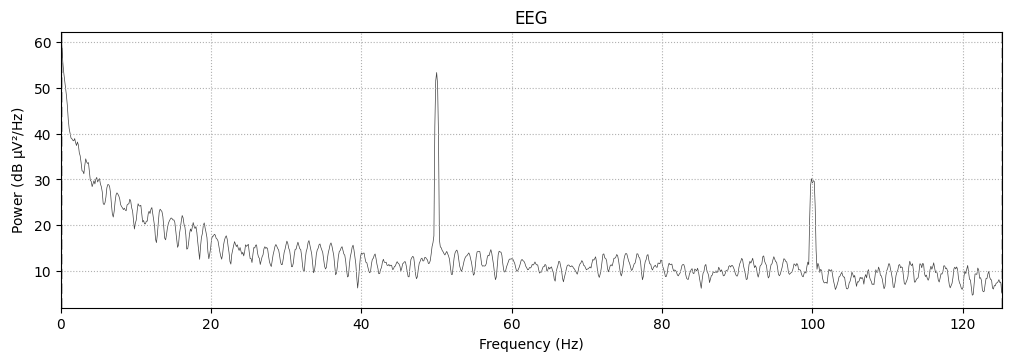

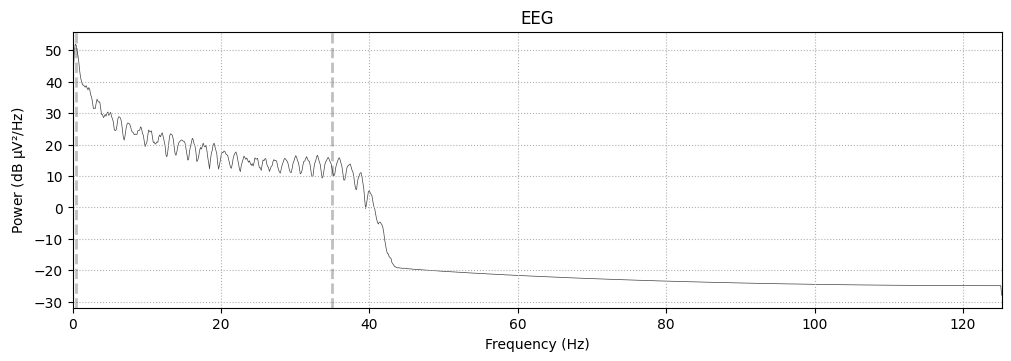

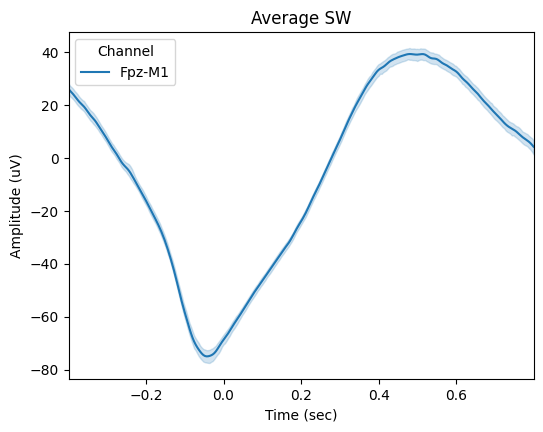

In [12]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="YASA pipeline")):
    yasa_df, cached, stdout, success_or_msg = process_file(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

# Artifacts

In [13]:
import os
import io

from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)


# Testing
artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts("C:\\dev\\play\\brainwave-data", "2025-02-12-20-34-56", False)
stdout, success_or_msg

('Processing file: C:\\dev\\play\\brainwave-data\\2025-02-12-20-34-56\\raw.fif\n',
 True)

In [14]:
from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Artifacts pipeline")):
# for idx, dir_name in enumerate(dirs):
    # print(dir_name)
    artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts(input_dir, dir_name, global_force)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Artifacts pipeline:   0%|          | 0/176 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,Processing file: C:\dev\play\brainwave-data\08...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,Processing file: C:\dev\play\brainwave-data\09...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,True,Processing file: C:\dev\play\brainwave-data\20...,True
3,2024-07-11-22-46-18,True,Processing file: C:\dev\play\brainwave-data\20...,True
4,2024-07-12-22-38-58,True,Processing file: C:\dev\play\brainwave-data\20...,True
...,...,...,...,...
171,2025-05-11-22-12-12,True,Processing file: C:\dev\play\brainwave-data\20...,True
172,2025-05-12-21-42-49,True,Processing file: C:\dev\play\brainwave-data\20...,True
173,2025-05-14-21-26-07,False,Processing file: C:\dev\play\brainwave-data\20...,True
174,compressed_files,False,Processing file: C:\dev\play\brainwave-data\co...,File not found C:\dev\play\brainwave-data\comp...


# Physiological pipeline

In [15]:
import traceback
import os

from importlib import reload
import run_physical_features_pipeline
reload(run_physical_features_pipeline)
import io
import contextlib
from datetime import datetime, timedelta


def process_file_for_physical(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    #     try:
        if os.path.exists(input_csv_file):
            yasa_df = pd.read_csv(input_csv_file)
            physical_features_df_30s, physical_features_df_1s, cached = run_physical_features_pipeline.cached_physical_features_pipeline(log, input_fif_file, yasa_df, force or global_force)
            return physical_features_df_30s, physical_features_df_1s, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, None, False, output_buffer.getvalue(), "File not found"
        # except Exception as e:
        #     return None, False, output_buffer.getvalue(), (str(e) + " " + traceback.format_exc())

# Testing
# physical_features_df_30s, physical_features_df_1s, cached, stdout, success_or_msg = process_file_for_physical("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", True)
# # display(stdout)
# display(success_or_msg)
# # display(physical_features_df_30s)

In [16]:
from tqdm.auto import tqdm

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Physiological pipeline")):
    _, _, cached, stdout, success_or_msg = process_file_for_physical(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Physiological pipeline:   0%|          | 0/176 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-15 09:03:55.843492 File not found: C:\...,File not found
1,09-07-2024--22-52-25,False,2025-05-15 09:03:55.844228 File not found: C:\...,File not found
2,2024-07-08-22-51-16,True,2025-05-15 09:03:55.850415 Loading cached 30s ...,True
3,2024-07-11-22-46-18,True,2025-05-15 09:03:55.863988 Loading cached 30s ...,True
4,2024-07-12-22-38-58,True,2025-05-15 09:03:55.876150 Loading cached 30s ...,True
...,...,...,...,...
171,2025-05-11-22-12-12,True,2025-05-15 09:04:02.061823 Loading cached 30s ...,True
172,2025-05-12-21-42-49,True,2025-05-15 09:04:02.105328 Loading cached 30s ...,True
173,2025-05-14-21-26-07,False,2025-05-15 09:04:02.147362 Generating 30s data...,True
174,compressed_files,False,2025-05-15 09:04:07.004652 File not found: C:\...,File not found


# Post-YASA pipeline

In [17]:
import traceback
import os

from importlib import reload
import run_post_yasa_pipeline
reload(run_post_yasa_pipeline)
import yasa_features
reload(yasa_features)


def process_file_for_post_yasa(root, dir_name, force=False):
    output_buffer = io.StringIO()
    # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

    input_fif_file = os.path.join(root, dir_name, "raw.fif")
    input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    artifacts_csv_path = os.path.join(root, dir_name, "raw.artifacts.csv")

    try:
        log(f"Processing file: " + input_fif_file)
        if os.path.exists(input_fif_file) and os.path.exists(input_csv_file) and os.path.exists(artifacts_csv_path):
            yasa_df = pd.read_csv(input_csv_file)
            artifacts_df = pd.read_csv(artifacts_csv_path)
            post_yasa_df, cached = run_post_yasa_pipeline.cached_post_yasa_pipeline(log, input_fif_file, yasa_df, stats_df, artifacts_df, force or global_force)
            return post_yasa_df, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, False, output_buffer.getvalue(), "File not found"
    except Exception as e:
        traceback.print_exc()
        return None, False, output_buffer.getvalue(), e

# Testing
# post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
# display(stdout)
# display(success_or_msg)

In [18]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

all_post_yasa_dfs = []

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post YASA pipeline")):
    post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa(input_dir, dir_name)
    all_post_yasa_dfs.append(post_yasa_df)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]
    # error_count = len(results[results['success_or_msg'] != True])
    # if (error_count > 5):
    #     log(f"Stopping due to {error_count} errors")
    #     break

results


Post YASA pipeline:   0%|          | 0/176 [00:00<?, ?it/s]

2025-05-15 09:04:07.174421 Processing file: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif
2025-05-15 09:04:07.174609 File not found: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif or C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.yasa.csv
2025-05-15 09:04:07.175593 Processing file: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif
2025-05-15 09:04:07.175746 File not found: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif or C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.yasa.csv
2025-05-15 09:04:07.176840 Processing file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv
2025-05-15 09:04:07.182633 Loading cached file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_yasa.csv
2025-05-15 09:04:07.439747 Processing file: C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
YASA file: C

Traceback (most recent call last):
  File "C:\Users\graha\AppData\Local\Temp\ipykernel_7544\404251101.py", line 23, in process_file_for_post_yasa
    artifacts_df = pd.read_csv(artifacts_csv_path)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1898, in _make_engine
    return mapping[engine](f, **self.options)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site

YASA file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.artifacts.csv
2025-05-15 09:04:27.890460 Loading cached file C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.post_yasa.csv
2025-05-15 09:04:28.092290 Processing file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.artifacts.csv
2025-05-15 09:04:28.101578 Loading cached file C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.post_yasa.csv
2025-05-15 09:04:28.231605 Processing file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.artifacts.csv
2025-05-15 09:04:28.238601 Loading cached file C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.post_yasa.csv
2025-05-15

c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
Traceback (most recent call last):
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\core\indexes\base.py", line 38

2025-05-15 09:04:52.340833 Processing file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.artifacts.csv
2025-05-15 09:04:52.351782 Loading cached file C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.post_yasa.csv
2025-05-15 09:04:52.508869 Processing file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.artifacts.csv
2025-05-15 09:04:52.516410 Loading cached file C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.post_yasa.csv
2025-05-15 09:04:52.811095 Processing file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.artifacts.csv
2025-05-15 09:04:52.823

c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)


    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative mu

2025-05-15 09:05:37.849210 All done! C:\dev\play\brainwave-data\2025-05-14-21-26-07\raw.fif
2025-05-15 09:05:37.864972 Saving to: C:\dev\play\brainwave-data\2025-05-14-21-26-07\raw.post_yasa.csv
2025-05-15 09:05:38.267596 Processing file: C:\dev\play\brainwave-data\compressed_files\raw.fif
2025-05-15 09:05:38.267831 File not found: C:\dev\play\brainwave-data\compressed_files\raw.fif or C:\dev\play\brainwave-data\compressed_files\raw.yasa.csv
2025-05-15 09:05:38.269914 Processing file: C:\dev\play\brainwave-data\nonnight\raw.fif
2025-05-15 09:05:38.269998 File not found: C:\dev\play\brainwave-data\nonnight\raw.fif or C:\dev\play\brainwave-data\nonnight\raw.yasa.csv


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,,File not found
1,09-07-2024--22-52-25,False,,File not found
2,2024-07-08-22-51-16,True,,True
3,2024-07-11-22-46-18,True,,True
4,2024-07-12-22-38-58,True,,True
...,...,...,...,...
171,2025-05-11-22-12-12,True,,True
172,2025-05-12-21-42-49,True,,True
173,2025-05-14-21-26-07,False,,True
174,compressed_files,False,,File not found


# Recalculate scalings
N.b. can be run frequently but will only be picked up by new runs.  Maybe worth occasionally regenerating all old files.
And yes, for new features have to rerun the pipeline on everything, then generate the stats here, then rerun the pipeline again on everything to have them use those.

In [19]:
# post_yasa_dfs_combined = pd.concat(all_post_yasa_dfs)

In [20]:
# from scaling import only_eeg

# only_eeg_cols = list(only_eeg(post_yasa_dfs_combined).columns)
# assert any(col.startswith("Main") for col in only_eeg_cols), "No column starting with 'Main' found in only_eeg_cols"

In [21]:
# #Expensive to do every time now
# import scaling
# reload(scaling)

# stats = scaling.stats(post_yasa_dfs_combined)
# stats.to_csv(input_dir + "/stats.csv")
# # assert any(stats['Column'].str.startswith("Main")), "No row starting with 'Main' found in column_name"
# stats

# Microwakings

In [22]:
# from models.microwakings_1 import microwakings_pipeline, microwakings1
# import os

# import io

# from importlib import reload
# reload(microwakings_pipeline)
# reload(microwakings1)

# def process_microwakings(root, dir_name, force=False):
#     output_buffer = io.StringIO()
#     # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
#     input_fif_file = os.path.join(root, dir_name, "raw.fif")
#     input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
#     try:
#         print(f"Processing file: " + input_fif_file, flush=True)
#         log(f"Processing file: " + input_fif_file)
#         tqdm.write(f"Processing file: " + input_fif_file)
#         if not os.path.exists(input_fif_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
#         if not os.path.exists(input_csv_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_csv_file

#         post_yasa_df = pd.read_csv(input_csv_file)
#         microwakings_df, cached = microwakings_pipeline.cached_microwakings_pipeline(log, input_fif_file, post_yasa_df, force or global_force)
#         return microwakings_df, cached, output_buffer.getvalue(), True
#     except Exception as e:
#         return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# microwakings_df, cached, stdout, success_or_msg = process_microwakings("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", False)
# stdout, success_or_msg

In [23]:
# results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

# dirs = next(os.walk(input_dir))[1]
# # for idx, dir_name in enumerate(tqdm(dirs, desc="Microwakings pipeline")):
# for idx, dir_name in enumerate(dirs):
#     # print(dir_name)
#     microwakings_df, cached, stdout, success_or_msg = process_microwakings(input_dir, dir_name, global_force)
#     results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

# results

# Post-human pipeline
This requires user interaction first to provide sleep times etc.

In [24]:
import sleep_events
from importlib import reload

reload(sleep_events)

from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [25]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)

from models.eeg_states.eeg_states import load_and_prepare_settling_eeg_state_events

tired_wired_eeg_state_events = load_and_prepare_settling_eeg_state_events()

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:132: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [26]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
import run_post_human_pipeline
reload(run_post_human_pipeline)
from run_post_human_pipeline import cached_post_human_pipeline


def process_file_for_post_human(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            if not os.path.exists(input_fif_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
            if not os.path.exists(input_csv_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_csv_file
            post_yasa_df = pd.read_csv(input_csv_file)
            post_human_df, cached = cached_post_human_pipeline(log, dir_name, input_fif_file, stats_df, days_data, post_yasa_df, tired_wired_eeg_state_events, force or global_force)
            return post_human_df, cached, output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
post_human_df, cached, stdout, success_or_msg = process_file_for_post_human("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", False)
stdout, success_or_msg

('2025-05-15 09:05:48.067956 Processing file: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-15 09:05:48.141447 Loading cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv\n',
 True)

In [27]:
from run_post_human_pipeline import cached_post_human_pipeline

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post human pipeline")):
    post_human_df, cached, stdout, success_or_msg = process_file_for_post_human(input_dir, dir_name, global_force   )
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Post human pipeline:   0%|          | 0/176 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-15 09:05:48.263442 Processing file: C:...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,2025-05-15 09:05:48.264892 Processing file: C:...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,False,2025-05-15 09:05:48.266926 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2025-05-15 09:05:49.862404 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2025-05-15 09:05:50.913551 Processing file: C:...,True
...,...,...,...,...
171,2025-05-11-22-12-12,True,2025-05-15 09:07:48.990915 Processing file: C:...,True
172,2025-05-12-21-42-49,False,2025-05-15 09:07:49.138533 Processing file: C:...,True
173,2025-05-14-21-26-07,False,2025-05-15 09:07:50.528283 Processing file: C:...,True
174,compressed_files,False,2025-05-15 09:07:52.042589 Processing file: C:...,File not found C:\dev\play\brainwave-data\comp...


# Stitch all pipelines together

In [28]:
import stitch_pipeline_results
reload(stitch_pipeline_results)
from stitch_pipeline_results import stitch_day_optimised

import io
import contextlib
import os

def process_pipeline_stitch(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        post_yasa_file = os.path.join(root, dir_name, "raw.post_yasa.csv")

        try:
            if os.path.exists(post_yasa_file):
                # Multiple consumers expect this file
                with_features = os.path.join(root, dir_name, "raw.with_features.csv")
                post_yasa_modification_time = os.path.getmtime(post_yasa_file)
                post_yasa_modification_date = datetime.fromtimestamp(post_yasa_modification_time)

                needs_creating = force

                if os.path.exists(with_features):
                    with_features_modification_time = os.path.getmtime(with_features)
                    with_features_modification_date = datetime.fromtimestamp(with_features_modification_time)

                    if post_yasa_modification_date > with_features_modification_date:
                        needs_creating = True
                        
                else:
                    needs_creating = True

                
                if needs_creating:
                    stitched = stitch_day_optimised(input_dir, dir_name, force or global_force)
                    assert("Main_eeg_sigmaabs" in stitched.columns), "Main_eeg_sigmaabs not found in stitched columns"
                    stitched.to_csv(with_features, index=False)

            return output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return output_buffer.getvalue(), "Error: " + str(e)


def format_stdout(stdout_content):
    """
    Format stdout content to make it more readable.
    
    Args:
        stdout_content: The raw stdout string
        
    Returns:
        Formatted string with proper line breaks and indentation
    """
    import re
    
    # Replace escaped newlines with actual newlines
    formatted = re.sub(r'\\n', '\n', stdout_content)
    
    # Remove other escape sequences
    formatted = re.sub(r'\\[rt]', '', formatted)
    
    # Split into lines for better handling
    lines = formatted.split('\n')
    
    # Process traceback to add indentation
    result = []
    indent_level = 0
    
    for line in lines:
        # Adjust indentation based on traceback structure
        if 'Traceback' in line:
            result.append("\n" + line)
            indent_level = 2
        elif line.strip().startswith('File '):
            result.append(" " * indent_level + line)
            indent_level = 4  # Increase indent for the next line
        elif indent_level > 0 and line.strip():
            result.append(" " * indent_level + line)
            if not line.startswith(' '):
                indent_level = 2  # Reset indent after the error message
        else:
            result.append(line)
    
    return '\n'.join(result)

# Display the formatted stdout
from IPython.display import display, HTML

def display_formatted_stdout(stdout_content):
    formatted = format_stdout(stdout_content)
    
    # Create styled HTML output
    html = f"""
    <div style="background-color: 'black'; padding: 10px; border-radius: 5px; font-family: monospace; white-space: pre-wrap; overflow-x: auto; border: 1px solid #ddd;">
    {formatted.replace('<', '&lt;').replace('>', '&gt;')}
    </div>
    """
    
    display(HTML(html))

# Example usage
stdout, success_or_msg = process_pipeline_stitch("C:\\dev\\play\\brainwave-data", "2025-05-11-22-12-12", True)
display_formatted_stdout(stdout)

# Testing
# display(stdout)
#, success_or_msg


In [29]:
from tqdm.auto import tqdm


results = pd.DataFrame(columns=['dir_name', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Stitching pipelines")):
    stdout, success_or_msg = process_pipeline_stitch(input_dir, dir_name, False)
    results.loc[len(results)] = [dir_name, stdout, success_or_msg]

results

Stitching pipelines:   0%|          | 0/176 [00:00<?, ?it/s]

,dir_name,stdout,success_or_msg
0,08-07-2024--22-51-16,,True
1,09-07-2024--22-52-25,,True
2,2024-07-08-22-51-16,,True
3,2024-07-11-22-46-18,,True
4,2024-07-12-22-38-58,,True
...,...,...,...
171,2025-05-11-22-12-12,,True
172,2025-05-12-21-42-49,,True
173,2025-05-14-21-26-07,,True
174,compressed_files,,True


# Analyse data completeness

In [30]:
# import os
# import pandas as pd
# from datetime import datetime
#
# dfs = []
# modification_times = []
#
# for root, dirs, files in os.walk(input_dir):
#     for idx, dir_name in enumerate(dirs):
#         input_file = os.path.join(root, dir_name, "raw.post_human.csv")
#         if os.path.exists(input_file):
#             df = pd.read_csv(input_file)
#             dfs.append(df)
#
#             # Get the last modification time of the file
#             mod_time = os.path.getmtime(input_file)
#             mod_time_dt = datetime.fromtimestamp(mod_time)
#             modification_times.append(mod_time_dt)
#
# # Concatenate all dataframes
# yasa_df = pd.concat(dfs, ignore_index=True)
#
# # Calculate the number of days from today for each modification time
# today = datetime.now()
# days_since_modification = [(today - mod_time).days for mod_time in modification_times]
#
# # Create a DataFrame with the modification times and days since modification
# modification_df = pd.DataFrame({
#     'file': [os.path.join(root, dir_name, "raw.post_human.csv") for root, dirs, files in os.walk(input_dir) for dir_name in dirs if os.path.exists(os.path.join(root, dir_name, "raw.post_human.csv"))],
#     'modification_time': modification_times,
#     'days_since_modification': days_since_modification
# })
#
# modification_df

# Upload to GCS

In [31]:
# Test
import upload
from importlib import reload
reload(upload)
from upload import upload_dir_to_gcs_skipping_existing, upload_dir_to_gcs

import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "examined-life-dd234" 

# Test
#upload_dir_to_gcs(lambda x: tqdm.write(x), 'examined-life-derived-eeg', "C:\\dev\\play\\brainwave-data\\2025-03-01-21-46-54", "2025-03-01-21-46-54")


In [32]:
import upload
reload(upload)

from upload import upload_dir_to_gcs_skipping_existing
import os

errors = []
dataframes = []

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs)):
# for root, dirs, files in os.walk(input_dir):
#     for dir_name in reversed(dirs):
    input_file = os.path.join(input_dir, dir_name, "raw.fif")
    full_dir_name = os.path.join(input_dir, dir_name)
    try:
        upload_dir_to_gcs_skipping_existing(lambda x: tqdm.write(x), 'examined-life-derived-eeg', full_dir_name, dir_name)
    except Exception as e:
        log("Error processing file: " + input_dir)
        errors.append("Error processing file: " + input_file + " - " + str(e))
        log(e)

for error in errors:
    log(error)

log("All uploaded")

  0%|          | 0/176 [00:00<?, ?it/s]

Skipping upload of C:\dev\play\brainwave-data\08-07-2024--22-51-16, no files modified since last checksum.
Skipping upload of C:\dev\play\brainwave-data\09-07-2024--22-52-25, no files modified since last checksum.
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_human.csv modified at 2025-05-15 09:05:49.852233, after Md5 file 2025-05-13 07:22:32.309795
C:\dev\play\brainwave-data\2024-07-08-22-51-16\directory_checksum.md5 uploading to 2024-07-08-22-51-16/directory_checksum.md5, does_not_exist=False has_changed=True
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwa

# Check if can delete Brainwave files that are safely backed up

In [33]:

import os

errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if full_input_filename.endswith(".brainflow.csv"):
            compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
            if os.path.exists(compressed_full_output_filename):
                can_delete.append({
                    'backed_up': compressed_full_output_filename,
                    'full_filename': full_input_filename
                })
            else:
                cannot_delete.append(full_input_filename)
    

In [34]:
can_delete_df = pd.DataFrame(can_delete)
can_delete_df

,backed_up,full_filename
0,C:\dev\play\brainwave-data\2024-12-28-21-33-53...,C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1,C:\dev\play\brainwave-data\2024-12-29-21-15-24...,C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2,C:\dev\play\brainwave-data\2024-12-30-21-34-52...,C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3,C:\dev\play\brainwave-data\2024-12-31-21-12-28...,C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4,C:\dev\play\brainwave-data\2025-01-01-21-42-08...,C:\dev\play\brainwave-data\2025-01-01-21-42-08...
...,...,...
58,C:\dev\play\brainwave-data\2025-05-10-21-36-29...,C:\dev\play\brainwave-data\2025-05-10-21-36-29...
59,C:\dev\play\brainwave-data\2025-05-11-20-59-57...,C:\dev\play\brainwave-data\2025-05-11-20-59-57...
60,C:\dev\play\brainwave-data\2025-05-11-22-12-12...,C:\dev\play\brainwave-data\2025-05-11-22-12-12...
61,C:\dev\play\brainwave-data\2025-05-12-21-42-49...,C:\dev\play\brainwave-data\2025-05-12-21-42-49...


In [35]:
cannot_delete

[]

In [36]:
can_delete_df['full_filename']

0     C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1     C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2     C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3     C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4     C:\dev\play\brainwave-data\2025-01-01-21-42-08...
                            ...                        
58    C:\dev\play\brainwave-data\2025-05-10-21-36-29...
59    C:\dev\play\brainwave-data\2025-05-11-20-59-57...
60    C:\dev\play\brainwave-data\2025-05-11-22-12-12...
61    C:\dev\play\brainwave-data\2025-05-12-21-42-49...
62    C:\dev\play\brainwave-data\2025-05-14-21-26-07...
Name: full_filename, Length: 63, dtype: object

# Check if can delete Cyton files that are safely backed up

In [37]:
import webserver
import bz2
import shutil
import os
import time


errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if file_name.startswith("OBCI_") and file_name.endswith(".TXT.bz2"):
            can_delete.append({
                'file_name': file_name.removesuffix(".bz2"),
                'full_filename': full_input_filename
            })

In [38]:
can_delete

[{'file_name': 'OBCI_0B.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-11\\OBCI_0B.TXT.bz2'},
 {'file_name': 'OBCI_0D.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-25-21-57-01\\OBCI_0D.TXT.bz2'},
 {'file_name': 'OBCI_1F.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-01-21-36-11\\OBCI_1F.TXT.bz2'},
 {'file_name': 'OBCI_22.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-04-21-13-39\\OBCI_22.TXT.bz2'},
 {'file_name': 'OBCI_23.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-05-21-09-46\\OBCI_23.TXT.bz2'},
 {'file_name': 'OBCI_F7.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-21-21-30-18\\OBCI_F7.TXT.bz2'},
 {'file_name': 'OBCI_03.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-23-21-24-02\\OBCI_03.TXT.bz2'},
 {'file_name': 'OBCI_08.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\compressed_files\\OBCI_08.TXT.bz2'}]

In [39]:
cyton_file_locations = [input_dir, "d:", "e:", "x:"]

for cyton_file_location in cyton_file_locations:
    for root, dirs, files in os.walk(cyton_file_location):
        for idx, file in enumerate(files):
            matching_record = next((f for f in can_delete if f['file_name'] == file), None)
            if matching_record:
                full_filename = os.path.join(root, file)
                log(f"Could delete {full_filename} as backed up in {matching_record['full_filename']}")

In [40]:
import memory

memory.garbage_collect(log)

2025-05-15 09:14:16.110862 Memory Usage: 2195.27 MB GC to 2194.27 MB


In [41]:
import ctypes

ctypes.windll.user32.MessageBoxW(0, "Compression is complete!", "Alert", 0x40 | 0x1)

1